# Actividad 2: PRÁCTICA DE CLASIFICACIÓN DE TEXTOS
## Borja Lacalle Álvarez

In [2]:
#importar librerias para el desarrollo de la actividad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import nltk

In [3]:
# leer dataset spam.csv
spam = pd.read_csv('spam.csv')
spam.head(10)



,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
# ver porcentaje de spam y no spam
spam['label'].value_counts(normalize=True)


label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

In [5]:
#normalizar el texto quitando signos de puntuacion y stopwords, entre otras cosas
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords

wpt = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))

def normalize_document(doc):
    doc = doc.replace("!", "").replace("¡", "").replace(",", "").replace(".", "").replace(";", "")
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [6]:
norm_spam=[]

for document in spam['text']:
    norm_spam.append(normalize_document(document))

#ver solo los primeros 20 documentos normalizados
norm_spam[:20]


['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 "free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry question ( std txt rate ) & c ' apply 08452810075over18 '",
 'u dun say early hor u c already say',
 "nah ' think goes usf lives around though",
 "freemsg hey darling ' 3 week ' word back ' like fun still ? tb ok xxx std chgs send å £ 150 rcv",
 'even brother like speak treat like aids patent',
 "per request ' melle melle ( oru minnaminunginte nurungu vettam )' set callertune callers press * 9 copy friends callertune",
 'winner valued network customer selected receivea å £ 900 prize reward claim call 09061701461 claim code kl341 valid 12 hours',
 'mobile 11 months ? u r entitled update latest colour mobiles camera free call mobile update co free 08002986030',
 "' gonna home soon ' want talk stuff anymore tonight k ? ' cried enough today",
 'six chances win cash 100 20000 pounds txt > c

In [7]:
#convertir norm_spam en una matriz tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(norm_spam)

tfidf_array = tfidf.toarray()
tfidf_array.shape


(5572, 9042)

In [8]:
#dividir el dataset en train (80%) y test (20%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf, spam['label'], test_size=0.2, random_state=42)


#### Clasificador bayesiano ingenuo (Naive Bayes)

In [9]:
# entenar modelo bayesiano ingenuo
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)


MultinomialNB()

In [10]:
#predecir con el modelo entrenado
y_pred = nb.predict(X_test)
y_pred

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'spam'], dtype='<U4')

In [11]:
#evaluar el modelo con la matriz de confusion
from sklearn.metrics import confusion_matrix

nb_conf = confusion_matrix(y_test, y_pred)
nb_conf


array([[965,   0],
       [ 37, 113]])

La estructura típica de una matriz de confusión binaria es la siguiente:

[[Verdaderos Negativos (TN), Falsos Positivos (FP)]  
 [Falsos Negativos (FN), Verdaderos Positivos (TP)]]

Por lo tanto, estos valores tienen el siguiente significado:

TN (True Negatives): La cantidad de mensajes clasificados correctamente como "ham" (no spam).  
FP (False Positives): La cantidad de mensajes que fueron clasificados incorrectamente como "spam" cuando en realidad son "ham".  
FN (False Negatives): La cantidad de mensajes que fueron clasificados incorrectamente como "ham" cuando en realidad son "spam".  
TP (True Positives): La cantidad de mensajes clasificados correctamente como "spam".



In [12]:
# evaluar el modelo con accuracy 
from sklearn.metrics import accuracy_score

nb_acc = accuracy_score(y_test, y_pred)
nb_acc


0.9668161434977578

El modelo acierta el 96.68% de las predicciones en el conjunto de evaluación. Es una medida de qué tan bien el modelo está clasificando correctamente los mensajes como spam o no spam.

#### Máquina SVM (SUPPORT VECTOR MACHINE)

In [13]:
# entrenar el modelo de svm
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [14]:
# predecir con el modelo entrenado
y_pred = svm.predict(X_test)
y_pred

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype=object)

In [15]:
# evaluar el modelo con la matriz de confusion
svm_conf = confusion_matrix(y_test, y_pred)
svm_conf

array([[963,   2],
       [ 29, 121]])

In [16]:
# evaluar el modelo con accuracy
svm_acc = accuracy_score(y_test, y_pred)
svm_acc

0.9721973094170404

In [17]:
# Aplicar oversampling a los datos de entrenamiento
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler()
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

y_train_resampled.value_counts(normalize=True)

label
ham     0.5
spam    0.5
Name: proportion, dtype: float64

In [18]:
# Crear y entrenar el modelo SVM con los datos resampleados
svm_model = SVC()
svm_model.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones en el conjunto de evaluación
svm_preds = svm_model.predict(X_test)

# Calcular la precisión (accuracy) y la matriz de confusión del modelo SVM
svm_accuracy = accuracy_score(y_test, svm_preds)
svm_confusion_matrix = confusion_matrix(y_test, svm_preds)

# Imprimir los resultados
print(f'Accuracy SVM con oversampling: {svm_accuracy}')
print(f'Confusion Matrix SVM con oversampling:\n{svm_confusion_matrix}')

Accuracy SVM con oversampling: 0.9739910313901345
Confusion Matrix SVM con oversampling:
[[963   2]
 [ 27 123]]


# explicar el oversampling


#### Árboles de Decisión


In [19]:
# entrenar el modelo de arbol de decision
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)


DecisionTreeClassifier()

In [20]:
# predecir con el modelo entrenado
y_pred = dt.predict(X_test)
y_pred

array(['ham', 'ham', 'ham', ..., 'ham', 'ham', 'spam'], dtype=object)

In [21]:
# evaluar el modelo con la matriz de confusion
dt_conf = confusion_matrix(y_test, y_pred)
dt_conf

array([[951,  14],
       [ 21, 129]])

In [22]:
# evaluar el modelo con accuracy
dt_acc = accuracy_score(y_test, y_pred)
dt_acc

0.968609865470852

In [35]:
# Imprimir el valor de precisión para cada modelo en porcentaje y redondeado a dos decimales
print(f'Accuracy Naive Bayesian: {round(nb_acc*100, 2)}%')  
print(f'Accuracy SVM: {round(svm_acc*100, 2)}%')
print(f'Accuracy Decision Tree: {round(dt_acc*100, 2)}%')

Accuracy Naive Bayesian: 96.68%
Accuracy SVM: 97.22%
Accuracy Decision Tree: 96.86%


#### ¿Tiene influencia en el resultado final el número máximo de features a utilizar?

In [23]:
#convertir norm_spam en una matriz tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_20 = tfidf_vectorizer.fit_transform(norm_spam)

tfidf_array = tfidf_20.toarray()
tfidf_array.shape

(5572, 5000)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_20, spam['label'], test_size=0.2, random_state=42)

In [25]:
# Crear y entrenar el modelo SVM con los datos resampleados
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de evaluación
svm_preds = svm_model.predict(X_test)

# Calcular la precisión (accuracy) y la matriz de confusión del modelo SVM
svm_accuracy = accuracy_score(y_test, svm_preds)
svm_confusion_matrix = confusion_matrix(y_test, svm_preds)

# Imprimir los resultados
print(f'Accuracy SVM: {svm_accuracy}')
print(f'Confusion Matrix SVM:\n{svm_confusion_matrix}')

Accuracy SVM: 0.9748878923766816
Confusion Matrix SVM:
[[963   2]
 [ 26 124]]


In [26]:
# Crear y entrenar el modelo SVM con los datos resampleados
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de evaluación
nb_preds = nb_model.predict(X_test)

# Calcular la precisión (accuracy) y la matriz de confusión del modelo SVM
nb_accuracy = accuracy_score(y_test, nb_preds)
nb_confusion_matrix = confusion_matrix(y_test, nb_preds)

# Imprimir los resultados
print(f'Accuracy naive bayesian: {nb_accuracy}')
print(f'Confusion Matrix naive bayesian:\n{nb_confusion_matrix}')

Accuracy naive bayesian: 0.9748878923766816
Confusion Matrix naive bayesian:
[[965   0]
 [ 28 122]]


In [27]:
# Crear y entrenar el modelo SVM con los datos resampleados
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de evaluación
dt_preds = dt_model.predict(X_test)

# Calcular la precisión (accuracy) y la matriz de confusión del modelo SVM
dt_accuracy = accuracy_score(y_test, dt_preds)
dt_confusion_matrix = confusion_matrix(y_test, dt_preds)

# Imprimir los resultados
print(f'Accuracy decision tree with 5000 features: {dt_accuracy}')
print(f'Confusion Matrix naive bayesian:\n{dt_confusion_matrix}')

Accuracy decision tree with 5000 features: 0.9668161434977578
Confusion Matrix naive bayesian:
[[949  16]
 [ 21 129]]


In [ ]:
print(f'Accuracy DT: {round(dt_acc*100, 2)}% VS Accuracy DT con 5000 features: {round(dt_accuracy*100, 2)}%')
print(f'Accuracy NB: {round(nb_acc*100, 2)}% VS Accuracy NB con 5000 features: {round(nb_accuracy*100, 2)}%' )
print(f'Accuracy SVM: {round(svm_acc*100, 2)}% VS Accuracy SVM con 5000 features: {round(svm_accuracy*100, 2)}%') 

Accuracy DT: 0.968609865470852 VS Accuracy DT con 5000 features: 0.9668161434977578
Accuracy NB: 0.9668161434977578 VS Accuracy NB con 5000 features: 0.9748878923766816
Accuracy SVM: 0.9721973094170404 VS Accuracy SVM con 5000 features: 0.9748878923766816


In [32]:
# Imprimir el valor de precisión en porcentaje y redondeado a dos decimales
print(f'Accuracy naive bayesian with 5000 features: {round(nb_accuracy*100, 2)}%')  
print(f'Accuracy SVM with 5000 features: {round(svm_accuracy*100, 2)}%')
print(f'Accuracy decision tree with 5000 features: {round(dt_accuracy*100, 2)}%')


Accuracy naive bayesian with 5000 features: 97.49%
Accuracy SVM with 5000 features: 97.49%
Accuracy decision tree with 5000 features: 96.68%


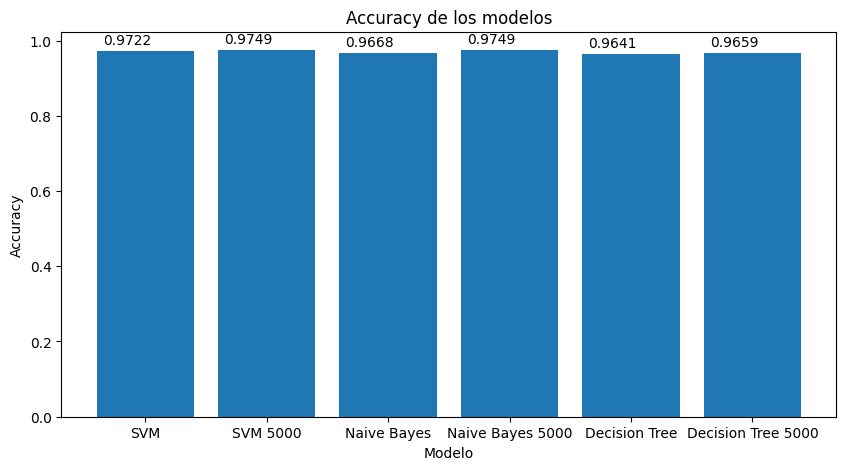

In [ ]:
#imprimir los resultados en un grafico comparando la precision de los modelos con max features y sin max features
plt.figure(figsize=(10, 5))
bars =plt.bar(['SVM','SVM 5000', 'Naive Bayes', 'Naive Bayes 5000','Decision Tree', 'Decision Tree 5000'], [svm_acc, svm_accuracy, nb_acc, nb_accuracy, dt_acc, dt_accuracy])
plt.title('Accuracy de los modelos')
plt.xlabel('Modelo')
plt.ylabel('Accuracy')

for bar, accuracy in zip(bars, [svm_acc, svm_accuracy, nb_acc, nb_accuracy, dt_acc, dt_accuracy]):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.01, f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()